In [1]:
from keras import layers, Input
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.random import set_seed as tf_seed

from api_key import TIINGO_API_KEY

In [2]:
# constants
INPUT_LENGTH = 200
OUTPUT_LENGTH = 40
REFERENCE_STOCK = "ALL"  # yes, that's a ticker, not a signal for training on all stocks

### Get Stock Data

In [ ]:
with open("stock list.txt", "r") as f:
    stock_list = f.readlines()
stock_list = [s.strip().replace(".", "-") for s in stock_list]

stock_dfs = []
for i in range(50):
    print(stock_list[10*i:10*(i+1)])
    stock_dfs.append(pdr.get_data_tiingo(stock_list[10*i:10*(i+1)], start="2000-01-01",
                                         api_key=TIINGO_API_KEY))

sp500_data = pd.concat(stock_dfs)
sp500_data.to_csv("sp500.csv")

In [3]:
sp500_data = pd.read_csv("sp500.csv",index_col=[0,1])
adj_closes = sp500_data["adjClose"].unstack("symbol")

## Clean Data

Turns out that several stocks don't have complete data in the test timeframes.  I don't know if keeping the stocks with incomplete data before the test window makes sense, given the scaling done later, so I just drop everything with a missing value.

In [4]:
full_adj_closes = adj_closes.loc[(adj_closes.index < "2019-12-31"), :].dropna(axis=1)
full_adj_closes.shape

(5030, 370)

In [41]:
def get_return_correlations(adj_close_df, ticker):
    returns = adj_close_df.pct_change().iloc[1:,:]
    correlations = returns.corr()
    correlations = correlations.loc[correlations.index != ticker, ticker]
    return correlations

In [42]:
correlations = get_return_correlations(full_adj_closes, REFERENCE_STOCK)
np.quantile(correlations, [0, 0.25, 0.5, 0.75, 1])

array([0.10957719, 0.29965404, 0.35403168, 0.42932382, 0.65370964])

Last train data is on 2019-10-31.

### Scaling & Splitting
We need to scale the different stocks so that the network always operates on the same scale.  However, to avoid leakage, we scale the data based only on what would be the training data.

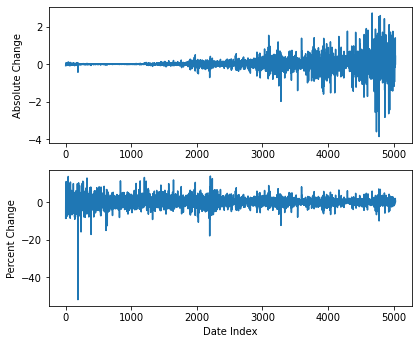

In [24]:
stock_data = full_adj_closes["AAPL"]
plt.subplot(2,1,1)
plt.plot(ALL_data.diff().values)
plt.ylabel("Absolute Change")

plt.subplot(2,1,2)
plt.plot(ALL_data.pct_change().values*100)
plt.xlabel("Date Index")
plt.ylabel("Percent Change")

fig = plt.gcf()
fig.set_size_inches(6.5, 5.5)
fig.savefig('price_changes.png')

In [25]:
class LogMinMaxScaler(MinMaxScaler):
    """
    Essentially a modified version of the MinMaxScaler, where fitting
    the scaler includes taking the base-10 logarithm of the data.
    """
    
    def fit(self, X, output_length, **fit_params):
        log_X = np.log10(X)
        log_X = log_X[:-(2*output_length),:]   # scale only the data used for training
        return super().fit(log_X, y=None, **fit_params)
    
    def transform(self, X):
        log_X = np.log10(X)
        return super().transform(log_X)
    
    def fit_transform(self, X, output_length, **fit_params):
        return self.fit(X, output_length, **fit_params).transform(X)
    
    def inverse_transform(self, X):
        log_X = super().inverse_transform(X)
        return np.power(10, log_X)

In [26]:
lmms = LogMinMaxScaler()
scaled_data = lmms.fit_transform(full_adj_closes.drop(REFERENCE_STOCK, axis=1).values, OUTPUT_LENGTH)

In [29]:
def make_input_output_data(data_series, history_length, future_length):
    shifted_data = {}
    for i in range(-future_length, history_length):
        shifted_data[f"d_{-1*i}"] = data_series.shift(periods=i)
    data_df = pd.DataFrame(shifted_data).dropna()
    data_df = data_df.iloc[:,::-1]
    input_data = data_df.iloc[:-(future_length),:history_length].copy()
    output_data = data_df.iloc[:-(future_length), history_length:].copy()
    test_input = data_df.iloc[-1, :history_length].copy()
    test_output = data_df.iloc[-1, history_length:].copy()
    return input_data.values, output_data.values, test_input.values, test_output.values

reference_closes = full_adj_closes[REFERENCE_STOCK]
ref_scaler = LogMinMaxScaler()
scaled_reference = ref_scaler.fit_transform(reference_closes.values.reshape([-1,1]), OUTPUT_LENGTH)
scaled_reference = pd.Series(scaled_reference.reshape([-1]))

train_in, train_out, ref_test_in, ref_test_out = make_input_output_data(scaled_reference,
                                                                        INPUT_LENGTH, OUTPUT_LENGTH)
train_in = train_in.reshape([*train_in.shape, 1])

In [30]:
def get_test_data(data_array, input_length, output_length):
    inputs = data_array[-(input_length + output_length):-(output_length)]
    outputs = data_array[-output_length:,:]
    return inputs, outputs

test_in, test_out = get_test_data(scaled_data, INPUT_LENGTH, OUTPUT_LENGTH)

### Set Up & Train Model

In [31]:
def make_stock_model(L1, L2):
    model = Sequential([
        Input(shape=[INPUT_LENGTH,1]),
        layers.LSTM(L1, return_sequences=False),
        layers.RepeatVector(OUTPUT_LENGTH),
        layers.LSTM(L2, return_sequences=True),
        layers.TimeDistributed(layers.Dense(1))
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
%%time

parameters = {"L1":[80,100,120,140], "L2":[80,100,120,140]}
model = KerasRegressor(build_fn=make_stock_model, epochs=8, batch_size=200)
ts_split = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=ts_split)

grid_search.fit(train_in, train_out)

In [ ]:
grid_search.best_params_

In [32]:
tf_seed(1)
final_model = make_stock_model(140, 140)
final_model.fit(train_in, train_out, epochs=8, batch_size=200)

Epoch 1/8
24/24 [==============================] - 1s 32ms/step - loss: 0.0459
Epoch 2/8
24/24 [==============================] - 1s 30ms/step - loss: 0.0083
Epoch 3/8
24/24 [==============================] - 1s 33ms/step - loss: 0.0048
Epoch 4/8
24/24 [==============================] - 1s 29ms/step - loss: 0.0032
Epoch 5/8
24/24 [==============================] - 1s 31ms/step - loss: 0.0020
Epoch 6/8
24/24 [==============================] - 1s 32ms/step - loss: 0.0015
Epoch 7/8
24/24 [==============================] - 1s 31ms/step - loss: 0.0016
Epoch 8/8
24/24 [==============================] - 1s 34ms/step - loss: 0.0013


### Make Predictions & Look at Error

In [33]:
def mean_absolute_percentage_error(y_true, y_pred, axis=None):
    return np.mean(np.abs((y_true - y_pred) / y_true), axis=axis) * 100

In [34]:
ref_prediction = final_model.predict(ref_test_in.reshape([1,-1,1]))

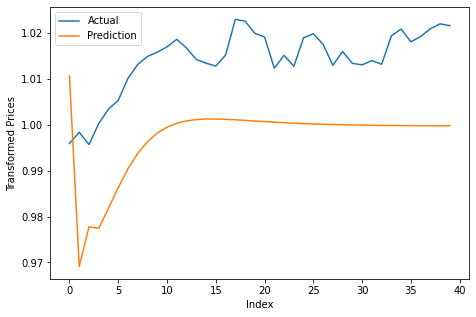

In [35]:
p1 = plt.plot(ref_test_out.reshape([-1]))
p2 = plt.plot(ref_prediction.reshape([-1]))
plt.legend((p1[0], p2[0]), ('Actual', 'Prediction'))
plt.xlabel("Index")
plt.ylabel("Transformed Prices")
fig = plt.gcf()
fig.set_size_inches(7.5, 5)
fig.savefig('scaled_reference_prediction.png')

In [36]:
mean_absolute_percentage_error(ref_prediction.reshape([-1]), ref_test_out.reshape([-1]))

1.771431502350249

In [37]:
unscaled_prediction = ref_scaler.inverse_transform(ref_prediction.reshape([-1,1]))
unscaled_test = ref_scaler.inverse_transform(ref_test_out.reshape([-1,1]))

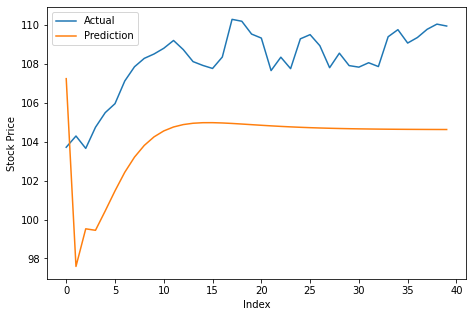

In [59]:
p1 = plt.plot(unscaled_test)
p2 = plt.plot(unscaled_prediction)
plt.legend((p1[0], p2[0]), ('Actual', 'Prediction'))
plt.xlabel("Index")
plt.ylabel("Stock Price")
fig = plt.gcf()
fig.set_size_inches(7.5, 5)
fig.savefig('unscaled_reference_prediction.png')

In [24]:
mean_absolute_percentage_error(unscaled_prediction, unscaled_test)

4.092220035446507

## The Other Predictions

In [38]:
test_in_array = test_in.transpose()
test_in_array = test_in_array.reshape([*test_in_array.shape, 1])
test_out_array = test_out.transpose()
test_out_predictions = final_model.predict(test_in_array)

In [39]:
test_out_mape = mean_absolute_percentage_error(test_out_array, test_out_predictions[:,:,0], axis=1)

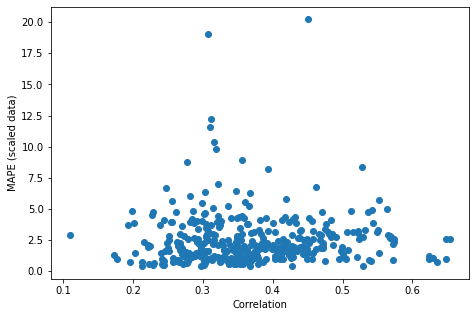

In [55]:
plt.scatter(correlations, test_out_mape)
plt.xlabel("Correlation")
plt.ylabel("MAPE (scaled data)")
fig = plt.gcf()
fig.set_size_inches(7.5, 5)
fig.savefig('scaled_scatterplot.png')

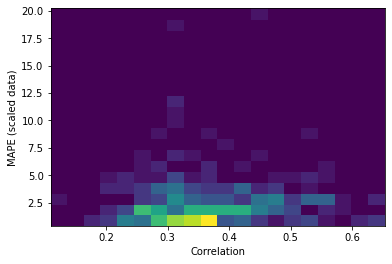

In [44]:
plt.hist2d(correlations, test_out_mape, bins=[20,20])
plt.xlabel("Correlation")
plt.ylabel("MAPE (scaled data)")
plt.show()

In [45]:
levels = ["<0.2", "0.2-0.3", "0.3-0.4", "0.4-0.5", "0.5-0.6", ">0.6"]
cuts = [0,0.2,0.3,0.4,0.5,0.6,1]
correlations_boxed = pd.cut(correlations, bins=cuts, labels=levels)

In [46]:
corr_df = pd.DataFrame({"Correlation":correlations_boxed, "MAPE":test_out_mape})
groups = [pd.DataFrame(x)["MAPE"] for _, x in corr_df.groupby("Correlation", as_index=False)]

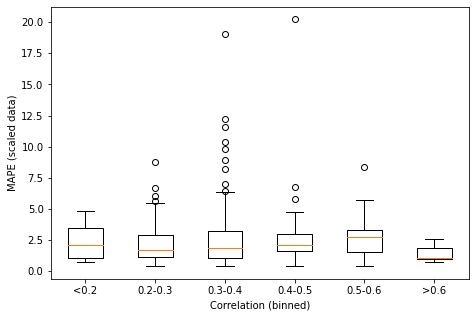

In [47]:
plt.boxplot(groups, labels=levels)
plt.xlabel("Correlation (binned)")
plt.ylabel("MAPE (scaled data)")
fig = plt.gcf()
fig.set_size_inches(7.5, 5)
fig.savefig('scaled_boxplot.png')

In [48]:
stats.f_oneway(*groups)

F_onewayResult(statistic=0.859307579038562, pvalue=0.5086123809619022)

In [49]:
unscaled_out = lmms.inverse_transform(test_out_array.transpose())
unscaled_predictions = lmms.inverse_transform(test_out_predictions[:,:,0].transpose())

In [50]:
unscaled_mape = mean_absolute_percentage_error(unscaled_out, unscaled_predictions, axis=0)

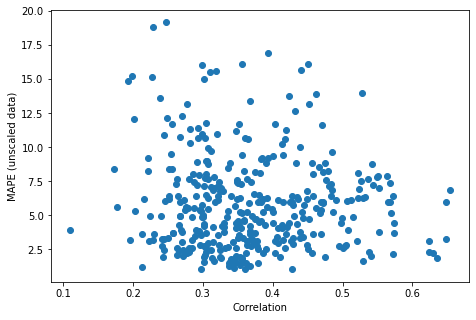

In [56]:
plt.scatter(correlations, unscaled_mape)
plt.xlabel("Correlation")
plt.ylabel("MAPE (unscaled data)")
fig = plt.gcf()
fig.set_size_inches(7.5, 5)
fig.savefig('unscaled_scatterplot.png')

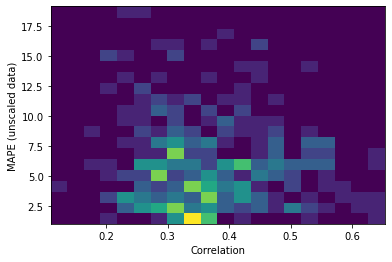

In [36]:
plt.hist2d(correlations, unscaled_mape, bins=[20,20])
plt.xlabel("Correlation")
plt.ylabel("MAPE (unscaled data)")
plt.show()

In [53]:
unscaled_corr_df = pd.DataFrame({"Correlation":correlations_boxed, "MAPE":unscaled_mape})
unscaled_groups = [pd.DataFrame(x)["MAPE"] for _, x in unscaled_corr_df.groupby("Correlation", as_index=False)]

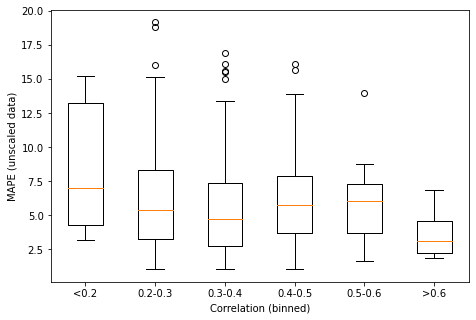

In [54]:
plt.boxplot(unscaled_groups, labels=levels)
plt.xlabel("Correlation (binned)")
plt.ylabel("MAPE (unscaled data)")
fig = plt.gcf()
fig.set_size_inches(7.5, 5)
fig.savefig('unscaled_boxplot.png')

In [39]:
stats.f_oneway(*unscaled_groups)

F_onewayResult(statistic=2.274528720161754, pvalue=0.046747350218964395)